# Pipeline example: mortality, fertility, emigration and immigration

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import time

from vivarium import InteractiveContext
from vivarium.framework.configuration import build_simulation_configuration
from vivarium.config_tree import ConfigTree

from vivarium_public_health.population import FertilityAgeSpecificRates
from vivarium_public_health.population import Mortality
from vivarium_public_health.population import Emigration
from vivarium_public_health.population import ImmigrationDeterministic as Immigration

from vivarium_public_health.population.spenser_population import TestPopulation
from vivarium_public_health.population.spenser_population import build_mortality_table
from vivarium_public_health.population.spenser_population import transform_rate_table
from vivarium_public_health.population.spenser_population import prepare_dataset
from vivarium_public_health.population.spenser_population import compute_migration_rates

from vivarium_public_health.utilities import read_config_file

## Base plugins for simulation

In [2]:
def base_plugins_simulation():
    config = {'required': {
                  'data': {
                      'controller': 'vivarium_public_health.testing.mock_artifact.MockArtifactManager',
                      'builder_interface': 'vivarium.framework.artifact.ArtifactInterface'
                  }
             }
    }

    return ConfigTree(config)

## Configure a simulation

In [3]:
def config_simulation(inp_file):
    
    if inp_file['prepare_data']['prepare']:
        # read a dataset (normally from daedalus), change columns to be readable by vivarium
        # this function creates a file saved at output_path
        prepare_dataset(
            dataset_path=inp_file['prepare_data']['path_to_dataset'], 
            output_path=inp_file['prepare_data']['path_to_output'],
            lookup_ethnicity=inp_file['prepare_data']['path_to_lookup_ethnicity'],
            columns_map=inp_file['prepare_data']['columns_map'],
            location_code=inp_file['prepare_data']['location_code']
        )
    
    # ============= CONFIGURATION
    if inp_file['configuration']['population']['population_size'] <= 0:
        pop_size = len(pd.read_csv(inp_file['paths']['path_to_pop_file']))
    else:
        pop_size = inp_file['configuration']['population']['population_size']
    
    # config object
    config = build_simulation_configuration()
    config.update({
        'time': {
            'start': inp_file['configuration']['time']['start'],
            'end': inp_file['configuration']['time']['end'],
            'step_size': inp_file['configuration']['time']['step_size']
        },
        'randomness': inp_file['configuration']['randomness'],
        'input_data': inp_file['configuration']['input_data'],
    }, 
        layer='model_override')
    
    config.update({
        'path_to_pop_file': inp_file['paths']['path_to_pop_file'],
        'path_to_mortality_file': inp_file['paths']['path_to_mortality_file'],
        'path_to_fertility_file': inp_file['paths']['path_to_fertility_file'],
        'path_to_emigration_file': inp_file['paths']['path_to_emigration_file'],
        'path_to_immigration_file': inp_file['paths']['path_to_immigration_file'],
        'path_to_total_population_file': inp_file['paths']['path_to_total_population_file'],
        
        'population': {
            'population_size': pop_size,
            'age_start': inp_file['configuration']['population']['age_start'],
            'age_end': inp_file['configuration']['population']['age_end'],
        },
        },
    )
    return config

## Create an interactive context manager

In [4]:
inp_file = read_config_file("../config/model_specification_pipeline_005.yaml")

base_plugins = base_plugins_simulation()
config = config_simulation(inp_file=inp_file)
components = [eval(x) for x in inp_file["list_components"]]
simulation = InteractiveContext(components=components,
                                configuration=config,
                                plugin_configuration=base_plugins,
                                setup=False)




Write the dataset at: ../persistant_data/test_ssm_E08000032_MSOA11_ppp_2011.csv


## Mortality rates

In [5]:
components

 FertilityAgeSpecificRates(),
 Mortality(),
 Emigration(),
 ImmigrationDeterministic()]

In [6]:
df = pd.read_csv(config.path_to_mortality_file)
# to save time, only look at locatiosn existing on the test dataset.
mortality_rate_df = df[(df['LAD.code']=='E09000002')]

asfr_data = transform_rate_table(mortality_rate_df,
                                      2011,
                                      2012,
                                      config.population.age_start,
                                      config.population.age_end)

simulation._data.write("cause.all_causes.cause_specific_mortality_rate", asfr_data)

In [7]:
mortality_rate_df.head()

,Unnamed: 0,LAD.name,LAD.code,ETH.group,MB.0,M0.1,M1.2,M2.3,M3.4,M4.5,...,F91.92,F92.93,F93.94,F94.95,F95.96,F96.97,F97.98,F98.99,F99.100,F100.101p
1,2,Barking and Dagenham,E09000002,WBI,0.003326,0.001683,0.000409,0.000261,0.000211,0.000194,...,0.164990,0.183852,0.204869,0.228290,0.254387,0.283468,0.315874,0.351984,0.392222,0.437060
390,391,Barking and Dagenham,E09000002,WHO,0.003453,0.001731,0.000405,0.000257,0.000197,0.000190,...,0.157919,0.176068,0.196304,0.218865,0.244019,0.272064,0.303332,0.338194,0.377062,0.420398
779,780,Barking and Dagenham,E09000002,MIX,0.003569,0.001777,0.000405,0.000264,0.000202,0.000190,...,0.159100,0.177560,0.198162,0.221154,0.246813,0.275450,0.307410,0.343078,0.382884,0.427309
1168,1169,Barking and Dagenham,E09000002,IND,0.003921,0.001948,0.000426,0.000262,0.000205,0.000206,...,0.155810,0.173602,0.193426,0.215513,0.240123,0.267543,0.298094,0.332133,0.370060,0.412317
1557,1558,Barking and Dagenham,E09000002,PAK,0.004396,0.002163,0.000434,0.000272,0.000222,0.000201,...,0.165502,0.183895,0.204332,0.227041,0.252273,0.280309,0.311462,0.346076,0.384537,0.427273


## Fertility rates


In [8]:
df = pd.read_csv(config.path_to_fertility_file)
# to save time, only look at locatiosn existing on the test dataset.
fertility_rate_df = df[(df['LAD.code']=='E09000002')]

asfr_data_fertility = transform_rate_table(fertility_rate_df,
                                      2011,
                                      2012,
                                      10,  # starting age for fertility
                                      50,  # finishing age for fertility
                                      [2]) # gender (only females [2])


simulation._data.write("covariate.age_specific_fertility_rate.estimate", asfr_data_fertility)


In [9]:
asfr_data_fertility.head()

,age_end,age_start,ethnicity,location,mean_value,sex,year_end,year_start
0,11,10,BAN,E09000002,0.001371,2,2012,2011
1,12,11,BAN,E09000002,0.005288,2,2012,2011
2,13,12,BAN,E09000002,0.018091,2,2012,2011
3,14,13,BAN,E09000002,0.031652,2,2012,2011
4,15,14,BAN,E09000002,0.050201,2,2012,2011


In [10]:
fertility_rate_df.head()

,LAD.name,LAD.code,ETH.group,F10.11,F11.12,F12.13,F13.14,F14.15,F15.16,F16.17,...,F91.92,F92.93,F93.94,F94.95,F95.96,F96.97,F97.98,F98.99,F99.100,F100.101p
1,Barking and Dagenham,E09000002,WBI,0.000026,0.000234,0.001569,0.003613,0.007285,0.013133,0.021530,...,0,0,0,0,0,0,0,0,0,0
390,Barking and Dagenham,E09000002,WHO,0.000029,0.000263,0.001764,0.004062,0.008189,0.014764,0.024203,...,0,0,0,0,0,0,0,0,0,0
779,Barking and Dagenham,E09000002,MIX,0.000001,0.000023,0.000294,0.000872,0.002184,0.004742,0.009128,...,0,0,0,0,0,0,0,0,0,0
1168,Barking and Dagenham,E09000002,IND,0.000012,0.000153,0.001286,0.003223,0.006976,0.013354,0.023028,...,0,0,0,0,0,0,0,0,0,0
1557,Barking and Dagenham,E09000002,PAK,0.001265,0.004877,0.016688,0.029197,0.046309,0.067626,0.092084,...,0,0,0,0,0,0,0,0,0,0


In [11]:
simulation.name

'simulation_context'

## Emigration

In [12]:
# setup emigration rates
df_emigration = pd.read_csv(config.path_to_emigration_file)
df_total_population = pd.read_csv(config.path_to_total_population_file)

df_emigration = df_emigration[
    (df_emigration['LAD.code'] == 'E09000002')]
df_total_population = df_total_population[
    (df_total_population['LAD'] == 'E09000002')]

asfr_data_emigration = compute_migration_rates(df_emigration, df_total_population, 
                                               2011, 
                                               2012, 
                                               config.population.age_start, 
                                               config.population.age_end)

In [13]:
asfr_data_emigration.head()

,age_end,age_start,ethnicity,location,mean_value,sex,year_end,year_start
0,1,0,BAN,E09000002,0.000000,1,2012,2011
1,2,1,BAN,E09000002,0.002178,1,2012,2011
2,3,2,BAN,E09000002,0.000000,1,2012,2011
3,4,3,BAN,E09000002,0.000000,1,2012,2011
4,5,4,BAN,E09000002,0.000000,1,2012,2011


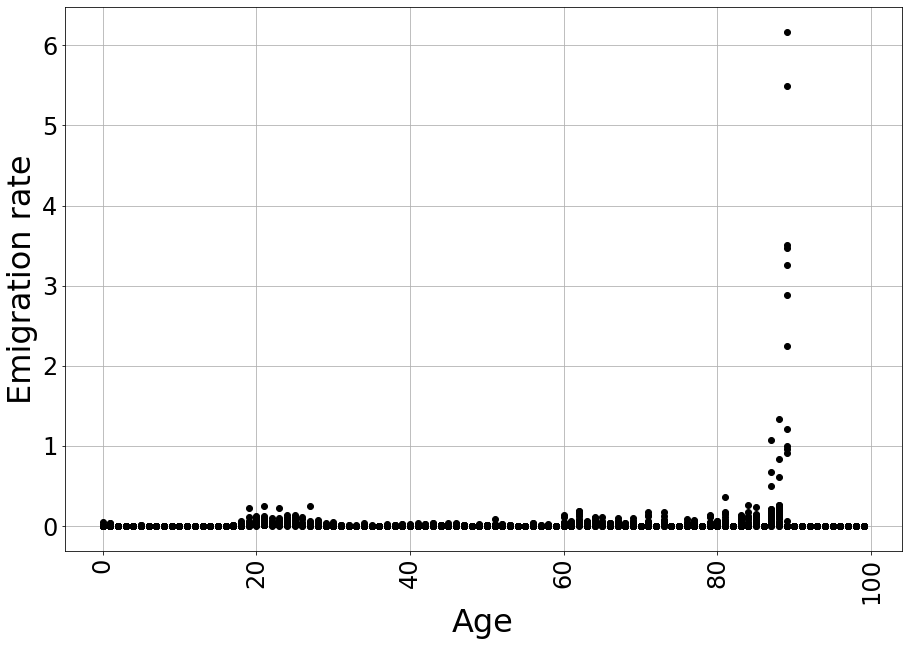

In [14]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(asfr_data_emigration["age_start"], 
         asfr_data_emigration["mean_value"], 
         '.', c='k', lw=4, markersize=12)
plt.xlabel("Age", size=32)
plt.ylabel("Emigration rate", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

In [15]:
simulation._data.write("covariate.age_specific_migration_rate.estimate", asfr_data_emigration)

## Immigration rates

In [16]:
# setup immigration rates
df_immigration = pd.read_csv(config.path_to_immigration_file)

df_immigration = df_immigration[
    (df_immigration['LAD.code'] == 'E09000002')]

asfr_data_immigration = compute_migration_rates(df_immigration, df_total_population, 
                                                2011, 
                                                2012, 
                                                config.population.age_start, 
                                                config.population.age_end,
                                                normalize=False
                                               )

In [17]:
# TESTING
# asfr_data_immigration.loc[asfr_data_immigration["age_start"] > 80, "mean_value"] = 100
asfr_data_immigration["mean_value"].describe()

count    2400.000000
mean        1.081231
std         3.195961
min         0.000000
25%         0.000000
50%         0.105836
75%         0.667866
max        34.451292
Name: mean_value, dtype: float64

In [18]:
# XXX CHECK!!!
total_immigrants = df_immigration[df_immigration.columns[4:]].sum().sum()

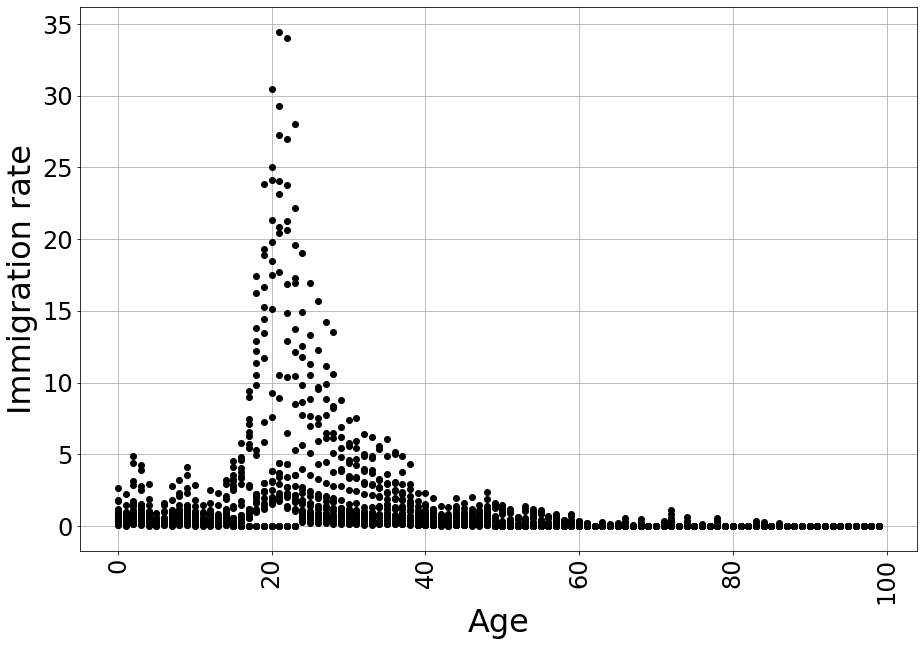

In [19]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(asfr_data_immigration["age_start"], 
         asfr_data_immigration["mean_value"], 
         '.', c='k', lw=4, markersize=12)
plt.xlabel("Age", size=32)
plt.ylabel("Immigration rate", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

In [20]:
simulation._data.write("cause.all_causes.cause_specific_immigration_rate", asfr_data_immigration)
simulation._data.write("cause.all_causes.cause_specific_total_immigrants_per_year", total_immigrants)

## Setup a simulation and run for `num_days`

In [ ]:
sim_start = time.time()

simulation.setup()
num_days = 365*10 + 10
simulation.run_for(duration=pd.Timedelta(days=num_days))

sim_end = time.time()

2020-07-22 10:37:46.435 | DEBUG    | vivarium.framework.values:register_value_modifier:373 - Registering metrics.1.population_manager.metrics as modifier to metrics
2020-07-22 10:37:47.261 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline fertility rate
2020-07-22 10:37:51.421 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline mortality_rate
2020-07-22 10:37:55.543 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline emigration_rate
2020-07-22 10:37:55.544 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline metrics


2020-07-22 10:38:44.692 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-01 00:00:00
2020-07-22 10:39:28.029 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-11 00:00:00
2020-07-22 10:40:16.032 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-21 00:00:00
2020-07-22 10:40:53.785 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-31 00:00:00
2020-07-22 10:41:57.828 | DEBUG    | vivarium.framework.engine:step:140 - 2011-02-10 00:00:00
2020-07-22 10:42:44.814 | DEBUG    | vivarium.framework.engine:step:140 - 2011-02-20 00:00:00
2020-07-22 10:43:27.910 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-02 00:00:00
2020-07-22 10:44:07.169 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-12 00:00:00
2020-07-22 10:44:50.123 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-22 00:00:00
2020-07-22 10:45:20.809 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-01 00:00:00
2020-07-22 10:46:07.680 | DEBUG    | vivarium.framework.engi

In [ ]:
pop = simulation.get_population()

print(f"Total time: {sim_end - sim_start}")
print (f'#alive: {len(pop[pop["alive"]=="alive"])}')
print (f'#dead: {len(pop[pop["alive"]!="alive"])}')
try:
    print (f'#new borns: {len(pop[pop["parent_id"]!=-1])}')
except Exception:
    print("Fertility component should be activated to print new borns!")

In [ ]:
#Total time: 17934.954960107803
#alive: 576350
#dead: 71531
#new borns: 99279

total_time_h = 17934.954960107803 / 3600.
print(total_time_h)
print(total_time_h * 66.5 / 0.5)

In [ ]:
pop["cause_of_death"].value_counts()

In [ ]:
pop[pop["cause_of_death"] == "all_causes"].head()

In [ ]:
pop1 = pop[pop["emigrated"] == "Yes"]
#pop2 = pop1[pop1["alive"] == "dead"]
pop1

## Plot results

In [ ]:
#min_time = pop["entrance_time"].min().strftime("%Y-%m-%d")
min_time = "2011-01-01"
max_time = datetime.datetime.strptime("2021-01-01", "%Y-%m-%d")

print("min_time:", min_time)
print("max_time:", max_time)

In [ ]:
# --- input
# intervals for plotting (in days)
interval_in_days = 10
# list of ethnicities
sel_ethnicity = ["WBI", "WHO"]

time_axis = []
curr_pop_axis = []
left_pop_axis = []
dead_pop_axis = []
immg_pop_axis = []
dead_immg_pop_axis = []
emig_pop_axis = []
new_babies_axis = []
avg_age_axis = []
std_age_axis = []
avg_age_adult_axis = []
std_age_adult_axis = []
pop_M_axis = []
pop_F_axis = []
pop_ETH_axis = []

curr_time = datetime.datetime.strptime(min_time, "%Y-%m-%d")
while curr_time <= max_time:
    time_axis.append(curr_time)
    
    curr_pop = pop[pop["entrance_time"] <= curr_time.strftime("%Y-%m-%d")]
    # dead population until current time (changes in the while loop)
    left_pop = curr_pop[curr_pop["exit_time"] <= curr_time.strftime("%Y-%m-%d")]
    dead_pop = left_pop[left_pop["emigrated"] != "Yes"]
    
    immg_pop = curr_pop[curr_pop["immigrated"] == "Yes"]
    dead_immg_pop = immg_pop[immg_pop["exit_time"] <= curr_time.strftime("%Y-%m-%d")]
    emig_pop = curr_pop[curr_pop["emigrated"] == "Yes"]
    new_babies = curr_pop[curr_pop["parent_id"] != -1]
    
    curr_alive_pop = curr_pop[curr_pop["alive"] == "alive"]
    curr_alive_adult_pop = curr_alive_pop[curr_alive_pop["age"] >= 20.]
    
    curr_pop_axis.append(len(curr_pop))
    left_pop_axis.append(len(left_pop))
    dead_pop_axis.append(len(dead_pop))
    immg_pop_axis.append(len(immg_pop))
    dead_immg_pop_axis.append(len(dead_immg_pop))
    emig_pop_axis.append(len(emig_pop))
    new_babies_axis.append(len(new_babies))
    avg_age_axis.append(curr_alive_pop["age"].mean())
    std_age_axis.append(curr_alive_pop["age"].std())
    avg_age_adult_axis.append(curr_alive_adult_pop["age"].mean())
    std_age_adult_axis.append(curr_alive_adult_pop["age"].std())
    
    curr_pop_male = len(curr_pop[curr_pop["sex"] == 1])
    pop_M = curr_pop_male - len(left_pop[left_pop["sex"] == 1])
    pop_M_axis.append(pop_M)
    
    curr_pop_female = len(curr_pop[curr_pop["sex"] == 2])
    pop_F = curr_pop_female - len(left_pop[left_pop["sex"] == 2])
    pop_F_axis.append(pop_F)
    
    curr_pop_eth = len(curr_pop[curr_pop["ethnicity"].isin(sel_ethnicity)])
    current_alive_population_eth = curr_pop_eth - len(left_pop[left_pop["ethnicity"].isin(sel_ethnicity)])
    pop_ETH_axis.append(current_alive_population_eth)
    
    # go to next time, according to the selected interval_in_days
    curr_time = datetime.datetime.strptime(curr_time.strftime("%Y-%m-%d"), "%Y-%m-%d")
    curr_time += datetime.timedelta(days=interval_in_days)

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
curr_pop_axis = np.array(curr_pop_axis)
left_pop_axis = np.array(left_pop_axis)
dead_pop_axis = np.array(dead_pop_axis)
immg_pop_axis = np.array(immg_pop_axis)
dead_immg_pop_axis = np.array(dead_immg_pop_axis)
emig_pop_axis = np.array(emig_pop_axis)
new_babies_axis = np.array(new_babies_axis)
avg_age_axis = np.array(avg_age_axis)
std_age_axis = np.array(std_age_axis)

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(time_axis, curr_pop_axis - left_pop_axis, 
         c='k', lw=4, 
         #marker="o",
         label="Total"
        )

plt.plot(time_axis, curr_pop_axis - dead_pop_axis - immg_pop_axis, 
         c='k', lw=4, ls='--', 
         #marker="o",
         label="Total - immigrants"
        )

plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

In [ ]:
# Population (gender)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, pop_M_axis, 
         c='k', lw=4, 
         #marker="o", 
         label="Male"
        )
plt.plot(time_axis, pop_F_axis, 
         c='r', lw=4, 
         #marker="o",
         label="Female"
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))

# XXX Emigrated population has very high values in the first time step
plt.plot(time_axis, emig_pop_axis - emig_pop_axis[0], 
         c='k', lw=4
         #marker="o"
        )
plt.xlabel("Time", size=32)
plt.ylabel("Emigrated", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

In [ ]:
# Population (total)
plt.figure(figsize=(15, 10))

plt.plot(time_axis, new_babies_axis, 
         c='k', lw=4,
         #marker="o"
         label="Newborns"
        )

plt.plot(time_axis, immg_pop_axis, 
         c='k', lw=4, ls='--',
         #marker="o"
         label="Immigrated"
        )

plt.plot(time_axis, dead_pop_axis, 
         c='r', lw=4, 
         #marker="o"
         label="Dead"
        )

plt.plot(time_axis, emig_pop_axis - emig_pop_axis[0], 
         c='r', lw=4, ls='--',
         #marker="o"
         label="Emigrated"
        )

plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

In [ ]:
# Population (total)
plt.figure(figsize=(15, 10))

plt.plot(time_axis[::10], avg_age_axis[::10], 
         c='k', lw=4,
         marker="o",
         label="Mean")

plt.errorbar(time_axis[::10], avg_age_axis[::10], 
             yerr=std_age_axis[::10], 
             fmt='ro', lw=2,
             #marker="o"
             label="std"
            )

plt.xlabel("Time", size=32)
plt.ylabel("Population Age", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.ylim(0, 100)
plt.grid()
plt.legend(fontsize=24)
plt.show()

In [ ]:
# Population (total)
plt.figure(figsize=(15, 10))

plt.plot(time_axis[::10], avg_age_adult_axis[::10], 
         c='k', lw=4,
         marker="o",
         label="Mean")

plt.errorbar(time_axis[::10], avg_age_adult_axis[::10], 
             yerr=std_age_adult_axis[::10], 
             fmt='ro', lw=2,
             #marker="o"
             label="std"
            )

plt.xlabel("Time", size=32)
plt.ylabel("Population Age (adult)", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.ylim(0, 100)
plt.grid()
plt.legend(fontsize=24)
plt.show()

In [ ]:
# Population (ethnicity)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, pop_ETH_axis, 
         c='k', lw=4, #marker="o", 
         label=sel_ethnicity
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

## Histograms

In [ ]:
# only immigrants
pop_immig = pop[pop["immigrated"] == "Yes"]
#pop_immig = pop_immig[pop_immig["parent_id"] == -1]

In [ ]:
pop["ethnicity"].value_counts()

In [ ]:
pop_immig['ethnicity'].value_counts()

In [ ]:
series2plot = pop_immig['ethnicity'].value_counts() / pop["ethnicity"].value_counts() * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("% of group population", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

In [ ]:
series2plot = pop_immig['ethnicity'].value_counts() / len(pop_immig["ethnicity"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("% of total population", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

In [ ]:
series2plot = pop_immig['sex'].value_counts() / len(pop_immig["sex"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Gender", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))

pop_immig["entrance_time"].hist(bins=int((365*10)/110), 
                           rwidth=0.9, 
                           color='k',
                           align='left'
                          )
plt.xlabel("Time", size=32)
plt.ylabel("Immigration", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

In [ ]:
pop